### Import librairies

In [100]:
import numpy as np
import tensorflow as tf
import keras
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
import copy
import math
from datetime import datetime

### Create your own dataset

Find the original code here : https://github.com/lzane/Fingers-Detection-using-OpenCV-and-Python

- Launch the following cell
- The blue rectangle is the interesting area
- Remove the background by pressing 'b' when the area is "empty" (i.e. you are not in here)
- Then move your hand in the area, you should see it in blank
- Each image is stored in ./data/i/imagej.png, where i is the number of finger relative to the picture you're currently saving, and j stands for the $j^{th}$ picture
- When you are done with one number of finger, just press esc to quit, change the finger_counter and do it for finger_counter between 0 and 5

- 20 frames per second during 2 minutes gives about $20*2*60 = 2400$ frames
- Vary your 'hand positions' to have some robustness
- If you move during the capture, feel free to press 'r' to reset the background
- If you have noisy pictures, you could implement some additional erode/dilate step

- Remove the black pictures, or bad pictures (with a wrong number of finger for an example) 

In [101]:
############################ TO CHANGE ####################
finger_counter = 3



# parameters
cap_region_x_begin=0.6
cap_region_y_end=1.6/3
threshold = 40 
blurValue = 21
bgSubThreshold = 50
learningRate = 0

# variables
isBgCaptured = 0   # bool, whether the background captured
triggerSwitch = False  # if true, keyborad simulator works

def printThreshold(thr):
    print("! Changed threshold to "+str(thr))


def removeBG(frame):
    # Remove the background
    fgmask = bgModel.apply(frame,learningRate=learningRate)
    kernel = np.ones((3, 3), np.uint8)
    fgmask = cv2.erode(fgmask, kernel, iterations=1)
    res = cv2.bitwise_and(frame, frame, mask=fgmask)
    return res

# Camera
camera = cv2.VideoCapture(0)
camera.set(10,200)
cv2.namedWindow('trackbar')
cv2.createTrackbar('trh1', 'trackbar', threshold, 100, printThreshold)

counter = 0

while camera.isOpened():
    ret, frame = camera.read()
    threshold = cv2.getTrackbarPos('trh1', 'trackbar')
    frame = cv2.bilateralFilter(frame, 5, 50, 100)  # smoothing filter
    frame = cv2.flip(frame, 1)  # flip the frame horizontally
    cv2.rectangle(frame, (int(cap_region_x_begin * frame.shape[1]), 0),
                 (frame.shape[1], int(cap_region_y_end * frame.shape[0])), (255, 0, 0), 2)
    cv2.imshow('original', frame)

    #  Main operation
    if isBgCaptured == 1:
        img = removeBG(frame)
        img = img[0:int(cap_region_y_end * frame.shape[0]),
                    int(cap_region_x_begin * frame.shape[1]):frame.shape[1]]  # clip the ROI
        #cv2.imshow('mask', img)

        # convert the image into binary image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (blurValue, blurValue), 0)
        #cv2.imshow('blur', blur)
        ret, thresh = cv2.threshold(blur, threshold, 255, cv2.THRESH_BINARY)
        cv2.imshow('output', thresh)
        
        path = 'data/'+str(finger_counter)+'/image'+datetime.now().strftime("%Y-%m-%dT%HH%MM%SS%f")+'.png'
        cv2.imwrite(path, cv2.resize(thresh, (56,56)))
    counter+=1

    # Keyboard OP
    k = cv2.waitKey(10)
    if k == 27:  # press ESC to exit
        camera.release()
        cv2.destroyAllWindows()
        break
    elif k == ord('b'):  # press 'b' to capture the background
        bgModel = cv2.createBackgroundSubtractorMOG2(0, bgSubThreshold)
        isBgCaptured = 1
        print( '!!!Background Captured!!!')
    elif k == ord('r'):  # press 'r' to reset the background
        bgModel = None
        triggerSwitch = False
        isBgCaptured = 0
        print ('!!!Reset BackGround!!!')
    elif k == ord('n'):
        triggerSwitch = True
        print ('!!!Trigger On!!!')

### Import the pictures

Once created, you can start learning your dataset.

You can multiply your dataset's size by adding other picture orientations. To do that, just run the following cell as python code.

for count_finger in range(6):
    
    path = "./data/picture/"+str(count_finger)+'/'
    
    for pict_name in os.listdir(path):

        img=cv2.imread(path+pict_name)

        # rotate ccw
        out=cv2.transpose(img)
        out=cv2.flip(out,flipCode=0)
        cv2.imwrite(path+pict_name[:-4]+'_left.png', out)
        
        #rotate cw
        out=cv2.transpose(img)
        out=cv2.flip(out,flipCode=1)

        cv2.imwrite(path+pict_name[:-4]+'_right.png', out)

for count_finger in range(6):
    path = "data/"+str(count_finger)+'/'
    for pict_name in os.listdir(path):
        if pict_name[len(pict_name)-5:len(pict_name)]=='t.png':
            os.remove(path+pict_name)

In [102]:
# all the pictures are stored in ./data/picture/i, where i  is the number of fingers relative to the pictures in the folder i

pict = []
labels =  []
path = ""

img_rows = 28
img_cols = 28

for count_finger in range(6):
    path = "data/"+str(count_finger)+'/'
    for pict_name in os.listdir(path):
        pict.append(cv2.cvtColor(cv2.resize(cv2.imread(path+pict_name),(img_rows, img_cols)), cv2.COLOR_BGR2GRAY))
        labels.append(count_finger)

In [103]:
x_train, x_test, y_train, y_test = train_test_split(pict, labels, train_size = 0.8)

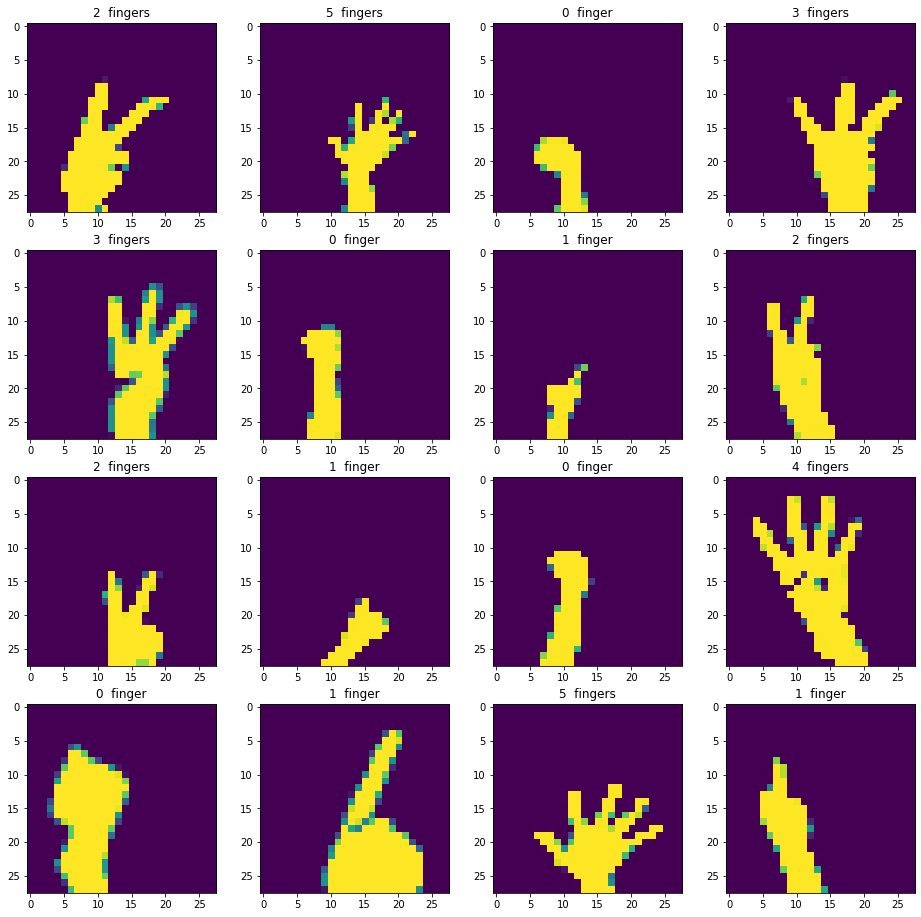

In [104]:
taille = 4
plt.subplots(nrows=taille,
             ncols=taille,
             figsize=(taille*taille,taille*taille))

for i in range(taille):
    for j in range(taille):
        indice = i*taille+j+1
        
        plt.subplot(taille,taille,indice) 
        plt.imshow(x_train[indice])
        plt.title(str(y_train[indice])+"  finger"+(y_train[indice]>=2)*"s")
plt.show()

In [105]:
# We have 6 classes, corresponding to the number between 0 and 5 (included)
num_classes = 6

x_train = np.array(x_train, dtype= np.float32)/255
x_test = np.array(x_test, dtype= np.float32)/255


if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(len(x_train), 1, img_rows, img_cols)
    x_test = x_test.reshape(len(x_test), 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("We split the data into : ")
print(len(x_train), "images dedicated to the training")
print(len(x_test), "images dedicated to the test")

We split the data into : 
30261 images dedicated to the training
7566 images dedicated to the test


In [106]:
x_train.shape

(30261, 28, 28, 1)

### Train the model

Following this blog : https://becominghuman.ai/real-time-finger-detection-1e18fea0d1d4

In [107]:
model = Sequential()
model.add(Conv2D(32, (2,2), activation='relu', input_shape=(img_rows, img_cols, 1)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(6, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [108]:
batch_size = 128

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 30261 samples, validate on 7566 samples
Epoch 1/10
30261/30261 [==============================] - 127s 4ms/step - loss: 0.6710 - accuracy: 0.7430 - val_loss: 0.1864 - val_accuracy: 0.9459
Epoch 2/10
30261/30261 [==============================] - 134s 4ms/step - loss: 0.1928 - accuracy: 0.9385 - val_loss: 0.0865 - val_accuracy: 0.9762
Epoch 3/10
30261/30261 [==============================] - 133s 4ms/step - loss: 0.1202 - accuracy: 0.9616 - val_loss: 0.0678 - val_accuracy: 0.9806
Epoch 4/10
30261/30261 [==============================] - 134s 4ms/step - loss: 0.0869 - accuracy: 0.9723 - val_loss: 0.0445 - val_accuracy: 0.9884
Epoch 5/10
30261/30261 [==============================] - 134s 4ms/step - loss: 0.0671 - accuracy: 0.9794 - val_loss: 0.0400 - val_accuracy: 0.9913
Epoch 6/10
30261/30261 [==============================] - 133s 4ms/step - loss: 0.0627 - accuracy: 0.9802 - val_loss: 0.0344 - val_accuracy: 0.9927
Epoch 7/10
30261/30261 [==============================] - 134s 

### Test the model

/home/drone/anaconda3/envs/comptage/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  del sys.path[0]


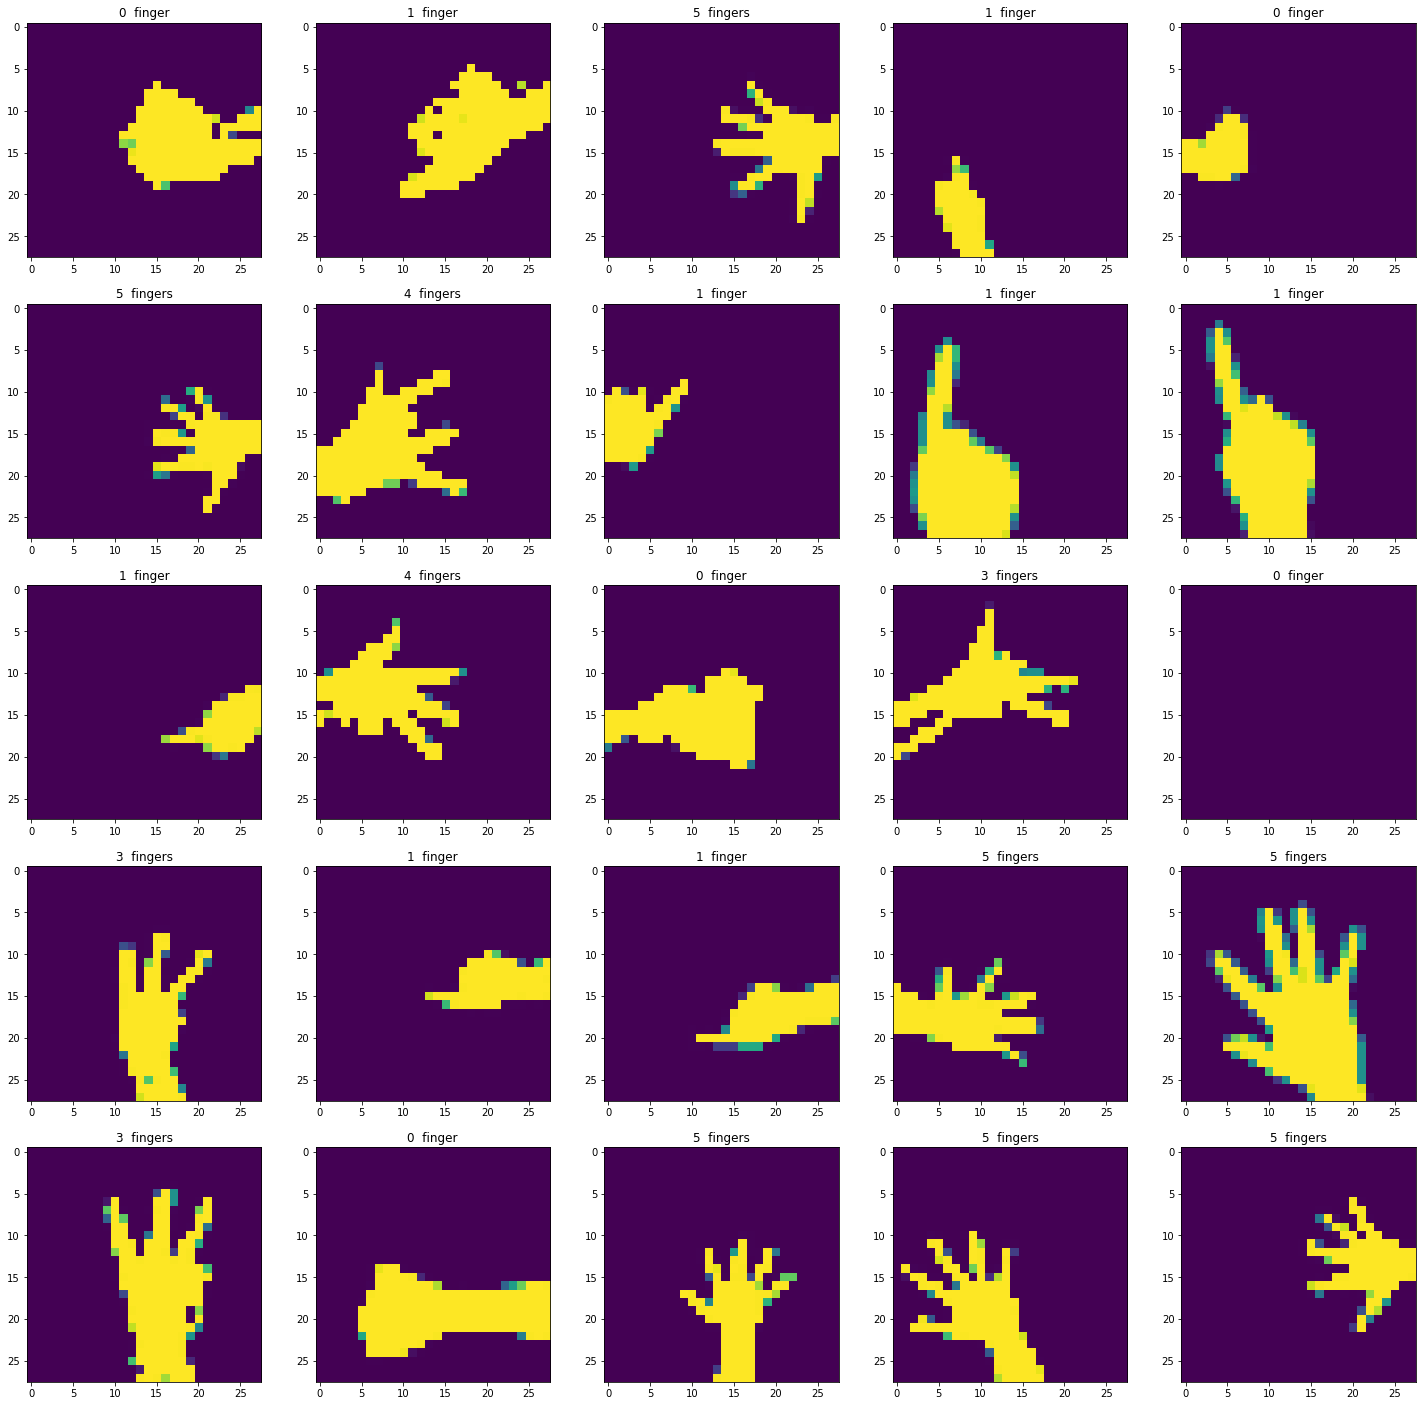

In [90]:
taille = 5
plt.subplots(nrows=taille,
             ncols=taille,
             figsize=(taille*taille,taille*taille))

for i in range(taille): 
    for j in range(taille):
        indice = i*taille+j+1
        img = x_test[indice].reshape(img_rows, img_cols)
        plt.subplot(taille,taille,indice)
        plt.imshow(img)
        count = np.argmax(model.predict(x_test[indice].reshape(1, img_rows, img_cols, 1)))
        plt.title(str(count)+"  finger"+(count>=2)*"s")
plt.show()

In [17]:
model.predict(x_test)

array([[1.12632844e-26, 1.14473728e-08, 7.99867809e-01, 2.00132176e-01,
        9.50872359e-09, 2.09215913e-12],
       [0.00000000e+00, 1.31413868e-38, 4.48483939e-28, 5.53947459e-13,
        2.72023215e-07, 9.99999762e-01],
       [7.76978814e-19, 8.79001831e-08, 1.08471885e-01, 7.71460116e-01,
        1.20067321e-01, 6.66808717e-07],
       ...,
       [4.78892426e-10, 9.69061375e-01, 3.09380926e-02, 6.14320186e-07,
        5.03575487e-16, 1.99615498e-12],
       [0.00000000e+00, 3.54082649e-19, 2.32414865e-10, 9.99999881e-01,
        9.40566025e-08, 1.20640965e-15],
       [1.01003741e-30, 4.88081020e-10, 9.04953922e-05, 9.99573410e-01,
        3.35862307e-04, 2.43032787e-07]], dtype=float32)

In [18]:
x_test.shape

(10988, 28, 28, 1)

## Save the model

In [109]:
version = 6
model.save("finger_low_resolution_v"+str(version)+".h5")

# Confusion matrix

from tensorflow.keras.models import load_model

model = load_model("finger_low_resolution_v3.h5")

In [111]:
pred = []

for i in range(len(x_test)):
    pred.append(np.argmax(model.predict(np.resize(x_test[i],(1,28,28,1)))))

In [112]:
import pandas as pd
pred = np.array(pred)
val = np.argmax(y_test, axis = 1)
pd.crosstab(pred, val, rownames=['pred'], colnames = ['True value'])

True value,0,1,2,3,4,5
pred,,,,,,
0,1128,0,6,3,1,2
1,3,1447,2,1,0,0
2,0,1,1237,3,2,0
3,0,0,2,1304,1,1
4,0,0,0,1,1019,0
5,0,0,0,1,2,1399


model.save("base2.h5")